## Imports

In [45]:
import psycopg2
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import chi2_contingency

## Connect to database

In [2]:
conn = psycopg2.connect(
    dbname="mimic",
    user="postgres",
    password="postgres",
    host="localhost"
)

## Create PATIENT_INFO table

In [3]:
query = """DROP TABLE IF EXISTS PATIENT_INFO;
CREATE TABLE PATIENT_INFO AS (
    WITH admissions_with_age AS (
        SELECT
            a.subject_id,
            a.admittime,
            p.dob,
            a.hadm_id,
            a.admission_type,
            ROW_NUMBER() OVER (PARTITION BY a.subject_id ORDER BY a.admittime ASC) AS admission_rank,
            CASE 
                WHEN EXTRACT(YEAR FROM AGE(a.ADMITTIME, p.DOB)) < 16 THEN NULL
                WHEN EXTRACT(YEAR FROM AGE(a.ADMITTIME, p.DOB)) >= 300 THEN 90
                ELSE EXTRACT(YEAR FROM AGE(a.ADMITTIME, p.DOB))
            END AS age
        FROM
            mimiciii.admissions a
        JOIN mimiciii.patients p ON a.subject_id = p.subject_id
        WHERE a.admission_type = 'EMERGENCY' OR a.admission_type = 'ELECTIVE'
    )
    SELECT
        subject_id,
        admission_type,
        hadm_id,
        age
    FROM
        admissions_with_age
    WHERE
        admission_rank = 1
        AND age IS NOT NULL
);
SELECT * FROM PATIENT_INFO"""
PATIENT_INFO = pd.read_sql_query(query, conn)
PATIENT_INFO.head()

,subject_id,admission_type,hadm_id,age
0,3,EMERGENCY,145834,76.0
1,4,EMERGENCY,185777,47.0
2,6,ELECTIVE,107064,65.0
3,9,EMERGENCY,150750,41.0
4,11,EMERGENCY,194540,50.0


## Create Elixhauser table

In [4]:
query = """
DROP TABLE IF EXISTS ELIXHAUSER_QUAN CASCADE;
CREATE TABLE ELIXHAUSER_QUAN AS
with icd as
(
  select hadm_id, seq_num, icd9_code
  from mimiciii.diagnoses_icd
  where seq_num != 1 -- we do not include the primary icd-9 code
)
, eliflg as
(
select hadm_id, seq_num, icd9_code
, CASE
  when icd9_code in ('39891','40201','40211','40291','40401','40403','40411','40413','40491','40493') then 1
  when SUBSTRING(icd9_code FROM 1 for 4) in ('4254','4255','4257','4258','4259') then 1
  when SUBSTRING(icd9_code FROM 1 for 3) in ('428') then 1
  else 0 end as CHF       /* Congestive heart failure */

, CASE
  when icd9_code in ('42613','42610','42612','99601','99604') then 1
  when SUBSTRING(icd9_code FROM 1 for 4) in ('4260','4267','4269','4270','4271','4272','4273','4274',
  '4276','4278','4279','7850','V450','V533') then 1
  else 0 end as ARRHY

, CASE
  when SUBSTRING(icd9_code FROM 1 for 4) in ('0932','7463','7464','7465','7466','V422','V433') then 1
  when SUBSTRING(icd9_code FROM 1 for 3) in ('394','395','396','397','424') then 1
  else 0 end as VALVE     /* Valvular disease */

, CASE
  when SUBSTRING(icd9_code FROM 1 for 4) in ('4150','4151','4170','4178','4179') then 1
  when SUBSTRING(icd9_code FROM 1 for 3) in ('416') then 1
  else 0 end as PULMCIRC  /* Pulmonary circulation disorder */

, CASE
  when SUBSTRING(icd9_code FROM 1 for 4) in ('0930','4373','4431','4432','4438','4439','4471','5571','5579','V434') then 1
  when SUBSTRING(icd9_code FROM 1 for 3) in ('440','441') then 1
  else 0 end as PERIVASC  /* Peripheral vascular disorder */

, CASE
  when SUBSTRING(icd9_code FROM 1 for 3) in ('401') then 1
  else 0 end as HTN       /* Hypertension, uncomplicated */

, CASE
  when SUBSTRING(icd9_code FROM 1 for 3) in ('402','403','404','405') then 1
  else 0 end as HTNCX     /* Hypertension, complicated */

, CASE
  when SUBSTRING(icd9_code FROM 1 for 4) in ('3341','3440','3441','3442','3443','3444','3445','3446','3449') then 1
  when SUBSTRING(icd9_code FROM 1 for 3) in ('342','343') then 1
  else 0 end as PARA      /* Paralysis */

, CASE
  when icd9_code in ('33392') then 1
  when SUBSTRING(icd9_code FROM 1 for 4) in ('3319','3320','3321','3334','3335','3362','3481','3483','7803','7843') then 1
  when SUBSTRING(icd9_code FROM 1 for 3) in ('334','335','340','341','345') then 1
  else 0 end as NEURO     /* Other neurological */

, CASE
  when SUBSTRING(icd9_code FROM 1 for 4) in ('4168','4169','5064','5081','5088') then 1
  when SUBSTRING(icd9_code FROM 1 for 3) in ('490','491','492','493','494','495','496','500','501','502','503','504','505') then 1
  else 0 end as CHRNLUNG  /* Chronic pulmonary disease */

, CASE
  when SUBSTRING(icd9_code FROM 1 for 4) in ('2500','2501','2502','2503') then 1
  else 0 end as DM        /* Diabetes w/o chronic complications*/

, CASE
  when SUBSTRING(icd9_code FROM 1 for 4) in ('2504','2505','2506','2507','2508','2509') then 1
  else 0 end as DMCX      /* Diabetes w/ chronic complications */

, CASE
  when SUBSTRING(icd9_code FROM 1 for 4) in ('2409','2461','2468') then 1
  when SUBSTRING(icd9_code FROM 1 for 3) in ('243','244') then 1
  else 0 end as HYPOTHY   /* Hypothyroidism */

, CASE
  when icd9_code in ('40301','40311','40391','40402','40403','40412','40413','40492','40493') then 1
  when SUBSTRING(icd9_code FROM 1 for 4) in ('5880','V420','V451') then 1
  when SUBSTRING(icd9_code FROM 1 for 3) in ('585','586','V56') then 1
  else 0 end as RENLFAIL  /* Renal failure */

, CASE
  when icd9_code in ('07022','07023','07032','07033','07044','07054') then 1
  when SUBSTRING(icd9_code FROM 1 for 4) in ('0706','0709','4560','4561','4562','5722','5723','5724','5728',
    '5733','5734','5738','5739','V427') then 1
  when SUBSTRING(icd9_code FROM 1 for 3) in ('570','571') then 1
  else 0 end as LIVER     /* Liver disease */

, CASE
  when SUBSTRING(icd9_code FROM 1 for 4) in ('5317','5319','5327','5329','5337','5339','5347','5349') then 1
  else 0 end as ULCER     /* Chronic Peptic ulcer disease (includes bleeding only if obstruction is also present) */

, CASE
  when SUBSTRING(icd9_code FROM 1 for 3) in ('042','043','044') then 1
  else 0 end as AIDS      /* HIV and AIDS */

, CASE
  when SUBSTRING(icd9_code FROM 1 for 4) in ('2030','2386') then 1
  when SUBSTRING(icd9_code FROM 1 for 3) in ('200','201','202') then 1
  else 0 end as LYMPH     /* Lymphoma */

, CASE
  when SUBSTRING(icd9_code FROM 1 for 3) in ('196','197','198','199') then 1
  else 0 end as METS      /* Metastatic cancer */

, CASE
  when SUBSTRING(icd9_code FROM 1 for 3) in
  (
     '140','141','142','143','144','145','146','147','148','149','150','151','152'
    ,'153','154','155','156','157','158','159','160','161','162','163','164','165'
    ,'166','167','168','169','170','171','172','174','175','176','177','178','179'
    ,'180','181','182','183','184','185','186','187','188','189','190','191','192'
    ,'193','194','195'
  ) then 1
  else 0 end as TUMOR     /* Solid tumor without metastasis */

, CASE
  when icd9_code in ('72889','72930') then 1
  when SUBSTRING(icd9_code FROM 1 for 4) in ('7010','7100','7101','7102','7103','7104','7108','7109','7112','7193','7285') then 1
  when SUBSTRING(icd9_code FROM 1 for 3) in ('446','714','720','725') then 1
  else 0 end as ARTH              /* Rheumatoid arthritis/collagen vascular diseases */

, CASE
  when SUBSTRING(icd9_code FROM 1 for 4) in ('2871','2873','2874','2875') then 1
  when SUBSTRING(icd9_code FROM 1 for 3) in ('286') then 1
  else 0 end as COAG      /* Coagulation deficiency */

, CASE
  when SUBSTRING(icd9_code FROM 1 for 4) in ('2780') then 1
  else 0 end as OBESE     /* Obesity      */

, CASE
  when SUBSTRING(icd9_code FROM 1 for 4) in ('7832','7994') then 1
  when SUBSTRING(icd9_code FROM 1 for 3) in ('260','261','262','263') then 1
  else 0 end as WGHTLOSS  /* Weight loss */

, CASE
  when SUBSTRING(icd9_code FROM 1 for 4) in ('2536') then 1
  when SUBSTRING(icd9_code FROM 1 for 3) in ('276') then 1
  else 0 end as LYTES     /* Fluid and electrolyte disorders */

, CASE
  when SUBSTRING(icd9_code FROM 1 for 4) in ('2800') then 1
  else 0 end as BLDLOSS   /* Blood loss anemia */

, CASE
  when SUBSTRING(icd9_code FROM 1 for 4) in ('2801','2808','2809') then 1
  when SUBSTRING(icd9_code FROM 1 for 3) in ('281') then 1
  else 0 end as ANEMDEF  /* Deficiency anemias */

, CASE
  when SUBSTRING(icd9_code FROM 1 for 4) in ('2652','2911','2912','2913','2915','2918','2919','3030',
    '3039','3050','3575','4255','5353','5710','5711','5712','5713','V113') then 1
  when SUBSTRING(icd9_code FROM 1 for 3) in ('980') then 1
  else 0 end as ALCOHOL /* Alcohol abuse */

, CASE
  when icd9_code in ('V6542') then 1
  when SUBSTRING(icd9_code FROM 1 for 4) in ('3052','3053','3054','3055','3056','3057','3058','3059') then 1
  when SUBSTRING(icd9_code FROM 1 for 3) in ('292','304') then 1
  else 0 end as DRUG /* Drug abuse */

, CASE
  when icd9_code in ('29604','29614','29644','29654') then 1
  when SUBSTRING(icd9_code FROM 1 for 4) in ('2938') then 1
  when SUBSTRING(icd9_code FROM 1 for 3) in ('295','297','298') then 1
  else 0 end as PSYCH /* Psychoses */

, CASE
  when SUBSTRING(icd9_code FROM 1 for 4) in ('2962','2963','2965','3004') then 1
  when SUBSTRING(icd9_code FROM 1 for 3) in ('309','311') then 1
  else 0 end as DEPRESS  /* Depression */
from icd
)
-- collapse the icd9_code specific flags into hadm_id specific flags
-- this groups comorbidities together for a single patient admission
, eligrp as
(
  select 
	hadm_id, max(chf) as chf, max(arrhy) as arrhy, max(valve) as valve, max(pulmcirc) as pulmcirc, 
  max(perivasc) as perivasc, max(htn) as htn, max(htncx) as htncx, max(para) as para, max(neuro) as neuro, 
  max(chrnlung) as chrnlung, max(dm) as dm, max(dmcx) as dmcx, max(hypothy) as hypothy, max(renlfail) as renlfail, 
  max(liver) as liver, max(ulcer) as ulcer, max(aids) as aids, max(lymph) as lymph, max(mets) as mets, max(tumor) as tumor, 
  max(arth) as arth, max(coag) as coag, max(obese) as obese, max(wghtloss) as wghtloss, max(lytes) as lytes, 
  max(bldloss) as bldloss, max(anemdef) as anemdef, max(alcohol) as alcohol, max(drug) as drug, max(psych) as psych, max(depress) as depress
from eliflg
group by hadm_id
)
-- now merge these flags together to define elixhauser
-- most are straightforward.. but hypertension flags are a bit more complicated

select adm.hadm_id, chf as CONGESTIVE_HEART_FAILURE, arrhy as CARDIAC_ARRHYTHMIAS, valve as VALVULAR_DISEASE, 
pulmcirc as PULMONARY_CIRCULATION, perivasc as PERIPHERAL_VASCULAR
-- we combine "htn" and "htncx" into "HYPERTENSION"
, case
    when htn = 1 then 1
    when htncx = 1 then 1
  else 0 end as HYPERTENSION
, para as PARALYSIS, neuro as OTHER_NEUROLOGICAL, chrnlung as CHRONIC_PULMONARY
-- only the more severe comorbidity (complicated diabetes) is kept
, case
    when dmcx = 1 then 0
    when dm = 1 then 1
  else 0 end as DIABETES_UNCOMPLICATED
, dmcx as DIABETES_COMPLICATED, hypothy as HYPOTHYROIDISM, renlfail as RENAL_FAILURE, liver as LIVER_DISEASE, ulcer as PEPTIC_ULCER, 
aids as AIDS, lymph as LYMPHOMA, mets as METASTATIC_CANCER
-- only the more severe comorbidity (metastatic cancer) is kept
, case
    when mets = 1 then 0
    when tumor = 1 then 1
  else 0 end as SOLID_TUMOR
, arth as RHEUMATOID_ARTHRITIS, coag as COAGULOPATHY, obese as OBESITY, wghtloss as WEIGHT_LOSS, lytes as FLUID_ELECTROLYTE, 
bldloss as BLOOD_LOSS_ANEMIA, anemdef as DEFICIENCY_ANEMIAS, alcohol as ALCOHOL_ABUSE, drug as DRUG_ABUSE, psych as PSYCHOSES
, depress as DEPRESSION

from mimiciii.admissions adm
left join eligrp eli
  on adm.hadm_id = eli.hadm_id
order by adm.hadm_id;

DROP TABLE IF EXISTS ELIXHAUSER_SUM;
CREATE TABLE ELIXHAUSER_SUM AS
(SELECT hadm_id,
       COALESCE(CONGESTIVE_HEART_FAILURE, 0) +
       COALESCE(CARDIAC_ARRHYTHMIAS, 0) +
       COALESCE(VALVULAR_DISEASE, 0) +
       COALESCE(PULMONARY_CIRCULATION, 0) +
       COALESCE(PERIPHERAL_VASCULAR, 0) +
       COALESCE(HYPERTENSION, 0) +
       COALESCE(PARALYSIS, 0) +
       COALESCE(OTHER_NEUROLOGICAL, 0) +
       COALESCE(CHRONIC_PULMONARY, 0) +
       COALESCE(DIABETES_UNCOMPLICATED, 0) +
       COALESCE(DIABETES_COMPLICATED, 0) +
       COALESCE(HYPOTHYROIDISM, 0) +
       COALESCE(RENAL_FAILURE, 0) +
       COALESCE(LIVER_DISEASE, 0) +
       COALESCE(PEPTIC_ULCER, 0) +
       COALESCE(AIDS, 0) +
       COALESCE(LYMPHOMA, 0) +
       COALESCE(SOLID_TUMOR, 0) +
       COALESCE(RHEUMATOID_ARTHRITIS, 0) +
       COALESCE(COAGULOPATHY, 0) +
       COALESCE(OBESITY, 0) +
       COALESCE(WEIGHT_LOSS, 0) +
       COALESCE(FLUID_ELECTROLYTE, 0) +
       COALESCE(BLOOD_LOSS_ANEMIA, 0) +
       COALESCE(DEFICIENCY_ANEMIAS, 0) +
       COALESCE(ALCOHOL_ABUSE, 0) +
       COALESCE(DRUG_ABUSE, 0) +
       COALESCE(PSYCHOSES, 0) +
       COALESCE(DEPRESSION, 0) AS Elixhauser_Score
FROM ELIXHAUSER_QUAN);
-- DELETE FROM ELIXHAUSER_SUM
-- WHERE Elixhauser_Score = 0;
SELECT * FROM ELIXHAUSER_SUM;
"""
elix_sum = pd.read_sql_query(query, conn)
elix_sum.head()

,hadm_id,elixhauser_score
0,100001,3
1,100003,2
2,100006,4
3,100007,1
4,100009,5


In [5]:
query = """
DROP TABLE IF EXISTS ELIXHAUSER_FINAL;
CREATE TABLE ELIXHAUSER_FINAL AS
(SELECT CONGESTIVE_HEART_FAILURE,
  CARDIAC_ARRHYTHMIAS,
  VALVULAR_DISEASE,
  PULMONARY_CIRCULATION,
  PERIPHERAL_VASCULAR,
  HYPERTENSION,
  PARALYSIS,
  OTHER_NEUROLOGICAL,
  CHRONIC_PULMONARY,
  DIABETES_UNCOMPLICATED,
  DIABETES_COMPLICATED,
  HYPOTHYROIDISM,
  RENAL_FAILURE,
  LIVER_DISEASE,
  PEPTIC_ULCER,
  AIDS,
  LYMPHOMA,
  SOLID_TUMOR,
  RHEUMATOID_ARTHRITIS,
  COAGULOPATHY,
  OBESITY,
  WEIGHT_LOSS,
  FLUID_ELECTROLYTE,
  BLOOD_LOSS_ANEMIA,
  DEFICIENCY_ANEMIAS,
  ALCOHOL_ABUSE,
  DRUG_ABUSE,
  PSYCHOSES,
  DEPRESSION
FROM ELIXHAUSER_QUAN as q
INNER JOIN ELIXHAUSER_SUM as s ON q.hadm_id = s.hadm_id);

SELECT * FROM ELIXHAUSER_FINAL;
"""
elix_final_df = pd.read_sql_query(query, conn)
elix_final_df.head()

,congestive_heart_failure,cardiac_arrhythmias,valvular_disease,pulmonary_circulation,peripheral_vascular,hypertension,paralysis,other_neurological,chronic_pulmonary,diabetes_uncomplicated,...,coagulopathy,obesity,weight_loss,fluid_electrolyte,blood_loss_anemia,deficiency_anemias,alcohol_abuse,drug_abuse,psychoses,depression
0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,1,0.0,0.0,0.0,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## List of Elixhauser conditions by patient

In [6]:
# Method to turn one_hot encoded columns into a column with a list of diseases
def get_one_hot_columns(row):
    return row[row == 1].index.tolist()

elix_final_df['categories'] = elix_final_df.apply(get_one_hot_columns, axis=1)

In [7]:
elix_final_df['categories']

0        [hypertension, diabetes_complicated, renal_fai...
1                            [hypertension, liver_disease]
2        [cardiac_arrhythmias, lymphoma, fluid_electrol...
3                                           [hypertension]
4        [cardiac_arrhythmias, peripheral_vascular, hyp...
                               ...                        
58971    [congestive_heart_failure, cardiac_arrhythmias...
58972    [congestive_heart_failure, cardiac_arrhythmias...
58973    [valvular_disease, peripheral_vascular, alcoho...
58974    [cardiac_arrhythmias, peripheral_vascular, hyp...
58975                                  [fluid_electrolyte]
Name: categories, Length: 58976, dtype: object

In [8]:
disease_frequency = elix_final_df['categories'].explode().value_counts()
df2 = disease_frequency/elix_final_df.shape[0]
df2

hypertension                0.467224
cardiac_arrhythmias         0.300800
fluid_electrolyte           0.258681
congestive_heart_failure    0.237571
chronic_pulmonary           0.188975
diabetes_uncomplicated      0.170900
renal_failure               0.138785
valvular_disease            0.102313
other_neurological          0.094293
coagulopathy                0.092410
hypothyroidism              0.090138
depression                  0.088036
liver_disease               0.086595
peripheral_vascular         0.071232
alcohol_abuse               0.070062
diabetes_complicated        0.061534
pulmonary_circulation       0.056616
obesity                     0.044696
drug_abuse                  0.035506
weight_loss                 0.035048
rheumatoid_arthritis        0.028876
deficiency_anemias          0.024722
solid_tumor                 0.024688
paralysis                   0.023077
blood_loss_anemia           0.016905
psychoses                   0.014362
lymphoma                    0.012242
p

In [48]:
disease_frequency['hypertension']

27555

## Visualizing the Network

### Population with RR

In [49]:
# Method to return a dictionary with all edges
def build_edge_dict(df, row, e_dict, pop):
    PAIR=2

    for disease_pair in combinations(row, PAIR):
        edge = frozenset({disease_pair[0], disease_pair[1]})
        denom = df[disease_pair[0]]*df[disease_pair[1]]
        numer = (1/pop)
        
        if edge in e_dict:
            e_dict[edge]['weight'] += numer/denom
            e_dict[edge]['occurrences'] += 1
        else:
            e_dict[edge] = {'weight': numer/denom, 'occurrences': 1}

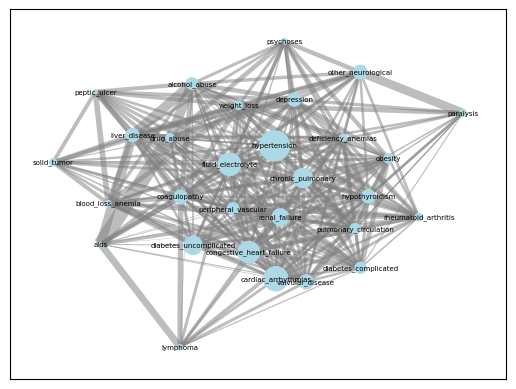

In [87]:
NODE_SCALE = 1000
EDGE_SCALE = 1.5
SPRING_CONST = 0.2
ALPHA_CONST = 0.5
FONT_SIZE = 5
TOTAL_POP = elix_final_df.shape[0]
edge_dict = {}

# Graphing the network
G = nx.Graph()

# Adding nodes
for disease, freq in df2.items():
    G.add_node(disease, size=freq*NODE_SCALE)
    
# Building the edge_dict
elix_final_df['categories'].apply(lambda row: build_edge_dict(df2, row, edge_dict, elix_final_df.shape[0]))

# Adding edges based on edge_dict
for edge, attrs in edge_dict.items():
    node1, node2 = edge
    
    # Only adding significant edges
    cont_table = [[attrs['occurrences'], disease_frequency[node1]], [disease_frequency[node2], TOTAL_POP]]
    chi2_stat, p_value, dof, expected = chi2_contingency(cont_table)
    if p_value < 0.05:
        G.add_edge(node1, node2, **attrs)
        
max_weight = max([d['weight'] for (u, v, d) in G.edges(data=True)])
min_weight = min([d['weight'] for (u, v, d) in G.edges(data=True)])
        
for (u, v, d) in G.edges(data=True):
    d['style'] = 'dashed' if d['weight'] < 1 else 'solid'
    d['weight_normalized'] = (d['weight'] - min_weight) / (max_weight - min_weight)
    d['alpha'] = d['weight_normalized'] * 0.9 + 0.1

# Graph params
pos = nx.spring_layout(G, k=SPRING_CONST)
sizes = [G.nodes[node]['size'] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color='lightblue')
edge_weights = [G[u][v]['weight']*EDGE_SCALE for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, alpha=d['alpha'], width=edge_weights, edge_color='grey', style=d['style'])
# , alpha=d['alpha']
nx.draw_networkx_labels(G, pos, font_size=FONT_SIZE)
plt.show()

In [78]:
weights = [d['weight'] for (u, v, d) in G.edges(data=True)]
max(weights)
# observed = [[40, 30], [20, 110]]

# # Perform the Chi-Square Test
# chi2_stat, p_value, dof, expected = chi2_contingency(observed)

# print("Chi2 Stat:", chi2_stat)
# print("P-value:", p_value)
# print("Degrees of Freedom:", dof)
# print("Expected Frequencies:", expected)

6.879206051224628

### Subgroups with Disease Prevalence

In [83]:
# Method to add edges row by row for subgroups
def add_edges_from_row(graph, row):
    for disease_pair in combinations(row, 2):
        if graph.has_edge(*disease_pair):
            graph[disease_pair[0]][disease_pair[1]]['weight'] += 1
        else:
            graph.add_edge(disease_pair[0], disease_pair[1], weight=1)

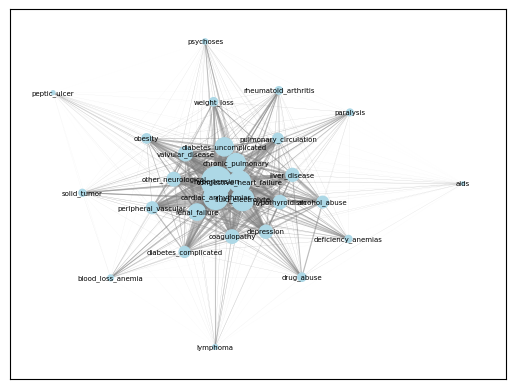

In [85]:
NODE_SCALE = 1000
EDGE_SCALE = 0.00125
SPRING_CONST = 12
ALPHA_CONST = 0.5

# Graphing the network
G = nx.Graph()

# Adding nodes
for disease, freq in df2.items():
    G.add_node(disease, size=freq*NODE_SCALE)
    
# Adding nodes
elix_final_df['categories'].apply(lambda row: add_edges_from_row(G, row))

# Graph params
pos = nx.spring_layout(G, k=SPRING_CONST)
sizes = [G.nodes[node]['size'] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color='lightblue')
edge_weights = [G[u][v]['weight']*EDGE_SCALE for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, alpha=ALPHA_CONST, width=edge_weights, edge_color='grey')
nx.draw_networkx_labels(G, pos, font_size=5)
plt.show()

In [65]:
conn.close()